In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import sys

# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
def eliminate_features(classifier, X, y ):
    iteration = 0
    print("Iteration= ", iteration)
    iteration += 1
    model_stats = {}
    drop_list = []
    # get baseline by identifying sorted important features using all of the provided features
    model_stats = utils.save_model_stats(classifier,X,y,model_stats)
    
    important_features = utils.display_important_features(classifier.feature_importances_, X,0)
    # least important feature
    least_important_label = important_features[-1][0]
    print("least_important label= ", least_important_label)
    
    drop_list.append(least_important_label)
    del important_features[-1]
    
    # drop list contains all of the feature labels except for the feature label identified as being most important
    list_count = len(important_features)
    while list_count > 0:
        print("Iteration= ", iteration)
        iteration += 1
        model_stats = utils.save_model_stats(classifier,X.drop(columns=drop_list),y,model_stats)
        least_important_label = important_features[-1][0]
        print("least_important label= ", least_important_label)
        drop_list.append(least_important_label)
        del important_features[-1]
        list_count-=1
    return model_stats


#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

In [3]:
summary_data = pd.read_csv(Path( '../Data/sr_summaries_kaggle_id.csv'))
print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]

(2773, 22)


,season,School,team_id,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,allow_fg_pct,ft_pct,allow_ft_att_avg,poss_avg,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
38,2009,Centenary (LA),NaN,29,-17.16,-5.08,0.276,70,80,0.416,0.49,0.733,25,80.641379,9,11,20,27,15,7,86.804071,21


In [4]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)

(2772, 22)


In [5]:
summary_data.rename(str.lower, axis='columns', inplace=True)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,allow_fg_pct,ft_pct,allow_ft_att_avg,poss_avg,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2009,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,31,-4.90,3.13,0.323,57,63,0.443,0.451,0.635,19,65.535484,7,8,20,22,12,5,86.975783,16
1,2009,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,35,2.82,-1.50,0.686,70,65,0.433,0.417,0.657,21,79.485714,13,11,22,22,13,6,88.066139,21
2,2009,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,32,10.34,6.62,0.531,68,64,0.441,0.424,0.707,19,76.562500,12,12,23,22,12,7,88.816327,19
3,2009,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,27,-20.19,-13.71,0.407,65,69,0.382,0.424,0.635,24,85.525926,13,15,23,27,16,9,76.000346,27
4,2009,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-14.41,-12.02,0.516,64,65,0.404,0.435,0.641,24,78.954839,12,10,22,23,16,7,81.058997,23


#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [6]:
# Read table of team names and associated team meta data
teams = pd.read_csv(Path('../Data/D1_teams.csv'))
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


,conf_name
id,
fe406882-9f22-495e-9df6-ef357a6803c6,Ivy
ca478771-aa3d-4231-81e0-b70f519134fb,Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34,Ivy
d60357bd-1205-42e9-9092-d986a2843a34,Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692,Ivy


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [7]:
tourney_data = pd.read_csv(Path('../Data/tournament_results.csv'))
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)



tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 9 columns):
season          2117 non-null int64
round           2117 non-null int64
game_date       2117 non-null object
win_seed        2117 non-null int64
win_market      2117 non-null object
win_team_id     2117 non-null object
lose_seed       2117 non-null int64
lose_market     2117 non-null object
lose_team_id    2117 non-null object
dtypes: int64(4), object(5)
memory usage: 148.9+ KB


In [8]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

,win_conf_name,count,percent,cum_percent
3,Atlantic Coast,431,20.358999,20.358999
9,Big Ten,313,14.785073,35.144072
24,Southeastern,269,12.706660,47.850732
5,Big 12,231,10.911667,58.762400
22,Pacific 12,197,9.305621,68.068021


Identify the conferences that have won 70% of all conference games

In [9]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 70]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']

The summary season data in this set goes back to 2010. If more training data is needed we can go back to earlier seasons.

So the intersection of season summary data with tournament data are regular seasons 2010 through 2016.

In [10]:
tourney_data = tourney_data[tourney_data['season'] >= 2010]
tourney_data.describe()['season']

count     533.000000
mean     2013.519700
std         2.284733
min      2010.000000
25%      2012.000000
50%      2014.000000
75%      2016.000000
max      2017.000000
Name: season, dtype: float64

In [11]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.rename(columns={"team_seed":"seed_t","opp_team_seed":"seed_o"}, inplace=True)

tourney_data['Game Result'] = tourney_data.game_result.map({1:'Win', 0:'Lose'})
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))

tourney_data.drop(columns=['school_t','school_o','games_t','games_o','team_id_o'],inplace=True)

tourney_data = tourney_data.join(teams, on='team_id_t', how='left')
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.rename(index=str,columns={'team':'team_t','opp_team':'team_o', 'opp_team_id':'team_id_o'},inplace=True)

tourney_data['game_result'] = tourney_data.game_result.apply(utils.negate_loser)
tourney_data.head()



,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10


In [12]:
computer_rankings = pd.read_csv(Path( '../Data/massey_seasons_with_id.csv'))
computer_rankings = computer_rankings[computer_rankings['season']>=2010]
computer_rankings[computer_rankings.isnull().any(axis=1)]

,SAG,WLK,WOL,Team,RTH,COL,POM,DOL,RPI,MOR,season,win_pct,kaggle_id


In [13]:
temp_merge = tourney_data.merge(computer_rankings, left_on=['season_t','team_id_t'], 
                                right_on=['season', 'kaggle_id'],how='left',suffixes=('','_y'))

temp_merge.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
temp_merge.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG,WLK,WOL,RTH,COL,POM,DOL,RPI,MOR
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3


In [14]:
tourney_comp_ratings = temp_merge.merge(computer_rankings,left_on=['season_t','team_id_o'], 
                                right_on=['season', 'kaggle_id'], how='left',suffixes=('_t','_o'))

tourney_comp_ratings.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)

tourney_comp_ratings.rename(str.lower, axis='columns', inplace=True)
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80


#### Add a feature
top_conf = 1 if team is a top conference and opponent is not
top_conf = -1 if opp_team is a top_conference and team is not
top_conf = 0 otherwise

In [15]:
print(top_tournament_conferences_list)
tourney_comp_ratings['top_conf'] = tourney_comp_ratings.apply(lambda row: utils.conf_compare(row.conf_name_t, 
                                                                                             row.conf_name_o,
                                                                                             top_tournament_conferences_list),
                                                              axis=1)

tourney_comp_ratings.head(10)[['game_result','conf_name_t','conf_name_o','top_conf']]

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']


,game_result,conf_name_t,conf_name_o,top_conf
0,-1,Atlantic Coast,American Athletic,1
1,1,American Athletic,Big Ten,-1
2,-1,Mid-American,Atlantic 10,0
3,1,Atlantic 10,American Athletic,0
4,-1,Big 12,Atlantic 10,1
5,1,Atlantic 10,Atlantic Coast,-1
6,-1,Big Ten,Atlantic 10,1
7,1,Atlantic 10,Big East,0
8,-1,Pacific 12,Atlantic 10,1
9,1,Atlantic 10,Pacific 12,-1


In [16]:
# Upsets occur less than 30% of the time when seeding deltas are more than 6
tourney_comp_ratings['upset_seed_threshold'] = tourney_comp_ratings.apply(
    lambda row: abs(row.seed_t - row.seed_o) > 6, axis=1).astype(int)
    
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1


In [17]:
tourney_comp_ratings['margin_victory_avg_t'] = tourney_comp_ratings['pts_avg_t'] - tourney_comp_ratings['opp_pts_avg_t']
tourney_comp_ratings['margin_victory_avg_o'] = tourney_comp_ratings['pts_avg_o'] - tourney_comp_ratings['opp_pts_avg_o']

tourney_comp_ratings['delta_margin_victory_avg'] = tourney_comp_ratings['margin_victory_avg_t'] - \
    tourney_comp_ratings['margin_victory_avg_o']

tourney_comp_ratings['delta_fg_pct'] = tourney_comp_ratings['fg_pct_t'] - tourney_comp_ratings['fg_pct_o']

#tourney_comp_ratings['allow_fg_pct'] = tourney_comp_ratings['allow_fg_pct_t'] - tourney_comp_ratings['allow_fg_pct_o']
tourney_comp_ratings['delta_off_rebs_avg'] = tourney_comp_ratings['off_rebs_avg_t'] - tourney_comp_ratings['off_rebs_avg_o']

tourney_comp_ratings['delta_def_rebs_avg'] = tourney_comp_ratings['def_rebs_avg_t'] - tourney_comp_ratings['def_rebs_avg_o']

tourney_comp_ratings['delta_allow_def_rebs_avg'] = tourney_comp_ratings['allow_def_rebs_avg_t'] - \
    tourney_comp_ratings['allow_def_rebs_avg_o']

tourney_comp_ratings['delta_ft_pct'] = tourney_comp_ratings['ft_pct_t'] - tourney_comp_ratings['ft_pct_o']

tourney_comp_ratings['to_net_avg_t'] = tourney_comp_ratings['to_avg_t'] - tourney_comp_ratings['steal_avg_t']

tourney_comp_ratings['to_net_avg_o'] = tourney_comp_ratings['to_avg_o'] - tourney_comp_ratings['steal_avg_o']

tourney_comp_ratings['delta_to_net_avg'] = tourney_comp_ratings['to_net_avg_t'] - tourney_comp_ratings['to_net_avg_o']

tourney_comp_ratings['delta_win_pct'] = tourney_comp_ratings['win_pct_t'] - tourney_comp_ratings['win_pct_o']

tourney_comp_ratings['delta_off_rating'] = tourney_comp_ratings['off_rating_t'] - tourney_comp_ratings['off_rating_o']

tourney_comp_ratings['delta_allow_off_rebs_avg'] = tourney_comp_ratings['allow_off_rebs_avg_t'] - \
    tourney_comp_ratings['allow_off_rebs_avg_o']

tourney_comp_ratings['delta_ft_att_avg'] = tourney_comp_ratings['ft_att_avg_t'] - tourney_comp_ratings['ft_att_avg_o']

tourney_comp_ratings['delta_allow_ft_att_avg'] = tourney_comp_ratings['allow_ft_att_avg_t'] -  \
    tourney_comp_ratings['allow_ft_att_avg_o']

tourney_comp_ratings['delta_seed'] = tourney_comp_ratings['seed_t'] - tourney_comp_ratings['seed_o']

tourney_comp_ratings['delta_srs'] = tourney_comp_ratings['srs_t'] - tourney_comp_ratings['srs_o']
tourney_comp_ratings['delta_sos'] = tourney_comp_ratings['sos_t'] - tourney_comp_ratings['sos_o']

tourney_comp_ratings['delta_sag'] = tourney_comp_ratings['sag_t'] - tourney_comp_ratings['sag_o']
tourney_comp_ratings['delta_wlk'] = tourney_comp_ratings['wlk_t'] - tourney_comp_ratings['wlk_o']
tourney_comp_ratings['delta_wol'] = tourney_comp_ratings['wol_t'] - tourney_comp_ratings['wol_o']
tourney_comp_ratings['delta_rth'] = tourney_comp_ratings['rth_t'] - tourney_comp_ratings['rth_o']
tourney_comp_ratings['delta_col'] = tourney_comp_ratings['col_t'] - tourney_comp_ratings['col_o']
tourney_comp_ratings['delta_pom'] = tourney_comp_ratings['pom_t'] - tourney_comp_ratings['pom_o']
tourney_comp_ratings['delta_dol'] = tourney_comp_ratings['dol_t'] - tourney_comp_ratings['dol_o']
tourney_comp_ratings['delta_rpi'] = tourney_comp_ratings['rpi_t'] - tourney_comp_ratings['rpi_o']
tourney_comp_ratings['delta_mor'] = tourney_comp_ratings['mor_t'] - tourney_comp_ratings['mor_o']


tourney_comp_ratings.drop(columns=['season_o'], inplace=True)


In [18]:
feature_data = tourney_comp_ratings.drop(columns=['round','game_date','seed_t','team_t','team_id_t','team_id_o',
                                         'team_o','seed_o','team_id_o','game_result','start_season','game result',
                                         'conf_name_t','conf_name_o']).copy()


feature_data.head()

,season_t,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0,7,5,2,0.068,0,3,-4,-0.042,6,3,3,-0.020,5.261076,2,3,-1,-1,4.80,1.97,-30,-31.0,1,-19,-8.0,-33.0,-13.0,-8.0,-28
1,2011,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0,8,1,7,0.008,2,3,-1,-0.026,4,6,-2,0.206,0.300109,3,3,-2,-3,0.37,-7.22,-13,-12.0,-18,-5,-12.0,-1.0,-14.0,-9.0,18
2,2013,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1,9,12,-3,0.005,-1,3,-2,-0.058,6,0,6,0.038,-3.771096,-1,2,-1,7,-8.78,-4.29,36,36.0,25,32,23.0,33.0,15.0,18.0,44
3,2012,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,9,15,-6,-0.072,2,-6,3,-0.063,1,6,-5,-0.012,-10.243325,1,1,0,7,-8.63,-3.17,40,33.0,16,38,24.0,37.0,18.0,26.0,45
4,2011,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1,17,5,12,0.074,1,6,-3,-0.036,6,3,3,0.221,6.725684,0,2,0,-10,15.54,3.84,-75,-53.0,-51,-72,-58.0,-81.0,-70.0,-48.0,-77


In [19]:
feature_data.drop(columns=['pts_avg_t','pts_avg_o', 'opp_pts_avg_t','opp_pts_avg_o',
                                'margin_victory_avg_t', 'margin_victory_avg_o',
                                'poss_avg_t','poss_avg_o',
                                'fg_pct_t','fg_pct_o','allow_fg_pct_t','allow_fg_pct_o',
                                'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                                'allow_def_rebs_avg_t','allow_def_rebs_avg_o','ft_pct_t','ft_pct_o',
                                'to_avg_t','to_avg_o','steal_avg_t','steal_avg_o',
                                'to_net_avg_t','to_net_avg_o',
                                'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                                'allow_off_rebs_avg_t','allow_off_rebs_avg_o',
                                'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                                'srs_t','srs_o','sos_t','sos_o',
                                'allow_ft_att_avg_t','allow_ft_att_avg_o',
                                'sag_t','sag_o','wlk_t','wlk_o','wol_t','wol_o',
                                'rth_t','rth_o','col_t','col_o','pom_t','pom_o',
                                'dol_t','dol_o','rpi_t','rpi_o','mor_t','mor_o'], inplace=True)




feature_data.head()

,season_t,top_conf,upset_seed_threshold,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,1,0,2,0.068,0,3,-4,-0.042,3,-0.020,5.261076,2,3,-1,-1,4.80,1.97,-30,-31.0,1,-19,-8.0,-33.0,-13.0,-8.0,-28
1,2011,-1,0,7,0.008,2,3,-1,-0.026,-2,0.206,0.300109,3,3,-2,-3,0.37,-7.22,-13,-12.0,-18,-5,-12.0,-1.0,-14.0,-9.0,18
2,2013,0,1,-3,0.005,-1,3,-2,-0.058,6,0.038,-3.771096,-1,2,-1,7,-8.78,-4.29,36,36.0,25,32,23.0,33.0,15.0,18.0,44
3,2012,0,1,-6,-0.072,2,-6,3,-0.063,-5,-0.012,-10.243325,1,1,0,7,-8.63,-3.17,40,33.0,16,38,24.0,37.0,18.0,26.0,45
4,2011,1,1,12,0.074,1,6,-3,-0.036,3,0.221,6.725684,0,2,0,-10,15.54,3.84,-75,-53.0,-51,-72,-58.0,-81.0,-70.0,-48.0,-77


In [20]:
X= feature_data[feature_data['season_t']>=2010]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['top_conf',
 'upset_seed_threshold',
 'delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_allow_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_allow_off_rebs_avg',
 'delta_ft_att_avg',
 'delta_allow_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(426, 26)
(426,)
(107, 26)
(107,)


,top_conf,upset_seed_threshold,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
140,0,1,2,0.069,-2,-2,-6,-0.008,2,0.081,5.170601,-1,-4,-2,-11,12.47,9.59,-101,-82.0,-105,-107,-94.0,-89.0,-110.0,-88.0,-94
293,0,0,-3,0.000,1,0,-4,-0.044,3,0.030,-5.202764,-4,0,-1,1,-2.42,0.22,10,14.0,5,3,3.0,14.0,1.0,4.0,8
368,-1,1,-4,0.032,-3,1,-1,0.016,2,-0.132,4.187608,0,-7,1,9,-14.49,-8.53,82,88.0,90,101,92.0,76.0,98.0,67.0,90
53,1,1,5,-0.006,7,3,-1,-0.085,0,0.118,-4.527964,1,5,5,-8,9.67,4.01,-56,-71.0,-63,-71,-74.0,-60.0,-68.0,-53.0,-54
33,0,0,1,-0.007,-1,0,-1,0.034,-1,-0.015,-0.684009,-1,-1,-3,2,-2.73,-3.85,7,9.0,3,8,5.0,6.0,10.0,6.0,16


#### Baseline Model

In [22]:
number_estimators = 201

bdt= AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME.R", n_estimators=number_estimators, 
                        learning_rate = 1.0)
    
bdt.fit(X_train, y_train)
score = bdt.score(X_train, y_train)
print("Training Model Score= ", score)


Training Model Score=  1.0


In [23]:

important_features = utils.display_important_features( bdt.feature_importances_, X_train)

Coefficient Values
delta_sos   0.16417910447761194
delta_win_pct   0.15422885572139303
delta_fg_pct   0.08955223880597014
delta_srs   0.05970149253731343
delta_rth   0.05472636815920398
delta_dol   0.05472636815920398
delta_ft_pct   0.04975124378109453
delta_sag   0.03980099502487562
delta_mor   0.03980099502487562
delta_allow_off_rebs_avg   0.029850746268656716
delta_wlk   0.029850746268656716
delta_pom   0.029850746268656716
delta_allow_def_rebs_avg   0.024875621890547265
delta_seed   0.024875621890547265
delta_wol   0.024875621890547265
delta_col   0.024875621890547265
delta_off_rating   0.01990049751243781
delta_rpi   0.01990049751243781
delta_off_rebs_avg   0.014925373134328358
delta_ft_att_avg   0.014925373134328358
delta_def_rebs_avg   0.009950248756218905
delta_to_net_avg   0.009950248756218905
delta_allow_ft_att_avg   0.009950248756218905
delta_margin_victory_avg   0.004975124378109453
top_conf   0.0
upset_seed_threshold   0.0


In [24]:
y_pred = bdt.predict(X_test)
print("Ada Boost model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

Ada Boost model accuracy is 0.71


array([[39, 13],
       [18, 37]], dtype=int64)

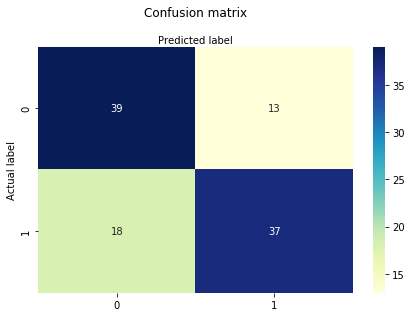

In [25]:
utils.display_confusion_matrix(y_test, y_pred)

##### Baseline Confusion Matrix

In [26]:
prediction_probabilities = bdt.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.7102803738317757
Precision: 0.74
Recall: 0.6727272727272727
Log loss=  0.6737219426946108


In [27]:
cross_val_scores = cross_val_score(bdt, X,y, cv=10, scoring='accuracy')
print("Baseline Cross Validation average= ",cross_val_scores.mean())

Baseline Cross Validation average=  0.7565244852980701


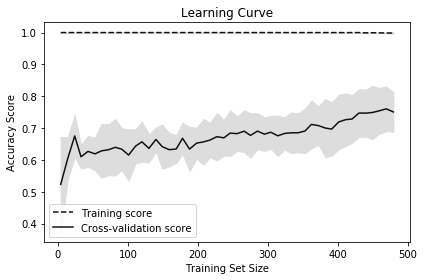

In [28]:
train_sizes, train_scores, test_scores = learning_curve(bdt, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

                   Baseline Learning Curve

#### Model Feature Optimization

In [29]:
X = feature_data[feature_data['season_t']>=2010]
X = X.drop(columns=['season_t'])
y = tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']

model_stats = eliminate_features(bdt, X,y)


Iteration=  0
least_important label=  upset_seed_threshold
Iteration=  1
least_important label=  top_conf
Iteration=  2
least_important label=  delta_margin_victory_avg
Iteration=  3
least_important label=  delta_allow_ft_att_avg
Iteration=  4
least_important label=  delta_to_net_avg
Iteration=  5
least_important label=  delta_def_rebs_avg
Iteration=  6
least_important label=  delta_ft_att_avg
Iteration=  7
least_important label=  delta_off_rebs_avg
Iteration=  8
least_important label=  delta_rpi
Iteration=  9
least_important label=  delta_off_rating
Iteration=  10
least_important label=  delta_col
Iteration=  11
least_important label=  delta_wol
Iteration=  12
least_important label=  delta_seed
Iteration=  13
least_important label=  delta_allow_def_rebs_avg
Iteration=  14
least_important label=  delta_pom
Iteration=  15
least_important label=  delta_wlk
Iteration=  16
least_important label=  delta_allow_off_rebs_avg
Iteration=  17
least_important label=  delta_mor
Iteration=  18
least

In [30]:
max_accuracy = 0
max_cross_val = 0
min_log_loss = 10000
for key, value in model_stats.items():
    accuracy = value['accuracy']
    cross_val = value['cross_validation']
    log_loss_val = value['log_loss']
    print('Accuracy= {0:6.4f} Cross Val= {1:6.4f}  Log Loss= {2:6.4f}'.format(accuracy ,cross_val, log_loss_val ))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        accuracy_hash = key
    if cross_val > max_cross_val:
        max_cross_val = cross_val
        cross_hash = key
    if log_loss_val < min_log_loss:
        min_log_loss = log_loss_val
        log_hash = key

print("\n")

print('Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['accuracy']))
print('Max Cross Validation= {0:6.4f}'.format( model_stats[cross_hash]['cross_validation']))
print ("Minimum Log Loss= {0:6.4f}".format(  model_stats[log_hash]['log_loss']))
print('Log Loss at Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['log_loss'] ))
print('Log Loss at Max Cross Validation= {0:6.4f} '.format( model_stats[cross_hash]['log_loss'] ))

Accuracy= 0.7103 Cross Val= 0.7565  Log Loss= 0.6737
Accuracy= 0.7103 Cross Val= 0.7510  Log Loss= 0.6737
Accuracy= 0.7103 Cross Val= 0.7546  Log Loss= 0.6737
Accuracy= 0.6636 Cross Val= 0.7494  Log Loss= 0.6735
Accuracy= 0.7009 Cross Val= 0.7565  Log Loss= 0.6769
Accuracy= 0.7383 Cross Val= 0.7568  Log Loss= 0.6766
Accuracy= 0.6636 Cross Val= 0.7509  Log Loss= 0.6771
Accuracy= 0.6916 Cross Val= 0.7490  Log Loss= 0.6773
Accuracy= 0.6822 Cross Val= 0.7640  Log Loss= 0.6779
Accuracy= 0.6636 Cross Val= 0.7529  Log Loss= 0.6773
Accuracy= 0.7103 Cross Val= 0.7884  Log Loss= 0.6759
Accuracy= 0.7103 Cross Val= 0.7679  Log Loss= 0.6758
Accuracy= 0.7477 Cross Val= 0.7829  Log Loss= 0.6757
Accuracy= 0.7196 Cross Val= 0.7813  Log Loss= 0.6758
Accuracy= 0.7383 Cross Val= 0.7833  Log Loss= 0.6764
Accuracy= 0.7477 Cross Val= 0.7812  Log Loss= 0.6754
Accuracy= 0.7196 Cross Val= 0.7791  Log Loss= 0.6771
Accuracy= 0.6822 Cross Val= 0.7790  Log Loss= 0.6721
Accuracy= 0.7196 Cross Val= 0.7660  Log Loss= 

In [31]:
model_features = model_stats[cross_hash]['labels']
print(model_features)

['delta_fg_pct', 'delta_win_pct', 'delta_srs', 'delta_sos', 'delta_rth', 'delta_dol']


In [32]:
X = feature_data[feature_data['season_t']>=2010][model_features]


array([[38, 14],
       [11, 44]], dtype=int64)

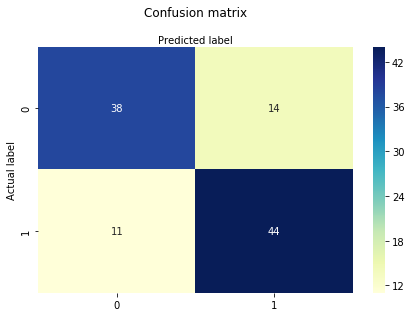

In [33]:
y = tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
bdt.fit(X_train, y_train)
y_pred = bdt.predict(X_test)
# save model stats
prediction_probabilities = bdt.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
log_loss_value = log_loss(y_test, prediction_probabilities)
cross_val_scores = cross_val_score(bdt, X,y, cv=10, scoring='accuracy')
cross_validation_average = cross_val_scores.mean()

train_sizes, train_scores, test_scores = learning_curve(bdt, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
utils.display_confusion_matrix(y_test, y_pred)



In [34]:
utils.display_important_features( bdt.feature_importances_, X_train)

Coefficient Values
delta_sos   0.26865671641791045
delta_win_pct   0.208955223880597
delta_dol   0.15920398009950248
delta_rth   0.15422885572139303
delta_fg_pct   0.10945273631840796
delta_srs   0.09950248756218906


[('delta_sos', 0.26865671641791045),
 ('delta_win_pct', 0.208955223880597),
 ('delta_dol', 0.15920398009950248),
 ('delta_rth', 0.15422885572139303),
 ('delta_fg_pct', 0.10945273631840796),
 ('delta_srs', 0.09950248756218906)]

In [35]:
prediction_probabilities = bdt.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.7663551401869159
Precision: 0.7586206896551724
Recall: 0.8
Log loss=  0.673339260571818


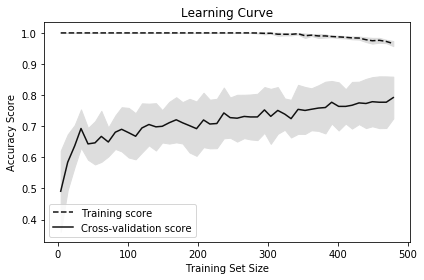

In [36]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [37]:
# Retrieve the non-normalized game stats
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_test.index)].copy()

test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs

#test_games['game_result'] = test_games.game_result.apply(negate_loser)

test_games.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob
7,2011,64,2011-03-18,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,6,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,1,2010,Win,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,14.61,10.39,0.656,70,66,0.475,0.387,0.734,19,73.850000,10,10,23,19,13,6,94.786730,17,Atlantic 10,Big East,77,55.0,54,74,59.0,84.0,72.0,49.0,80,16,19.0,16,17,16.0,31.0,19.0,13.0,42,0,0,5,4,1,-0.041,0,-2,5,-0.019,3,7,-4,0.044,-0.422030,0,3,-1,5,-6.05,-6.61,61,36.0,38,57,43.0,53.0,53.0,36.0,38,1,0.504640
28,2012,64,2012-03-16,5,Temple,8598d1b6-106b-4083-a512-2e495729525a,12,South Florida,55af9c69-3675-4b9b-a882-96640b782fff,-1,2011,Lose,10.44,4.94,0.750,75,69,0.469,0.435,0.719,19,77.743750,10,11,21,22,12,7,96.470777,19,9.20,7.29,0.611,59,56,0.437,0.386,0.705,16,69.133333,10,10,20,20,13,5,85.342334,16,American Athletic,American Athletic,36,29.0,28,35,22.0,34.0,20.0,20.0,42,70,51.0,60,53,59.0,66.0,60.0,52.0,47,0,1,6,3,3,0.032,0,1,2,0.014,5,8,-3,0.139,11.128444,1,3,3,-7,1.24,-2.35,-34,-22.0,-32,-18,-37.0,-32.0,-40.0,-32.0,-5,-1,0.495969
34,2017,32,2017-03-19,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,3,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,-1,2016,Lose,12.88,4.62,0.714,73,65,0.454,0.406,0.668,24,77.840000,11,10,25,23,11,6,93.782117,22,20.80,8.38,0.846,78,65,0.481,0.403,0.712,15,77.917949,10,10,26,22,11,6,100.105305,20,Atlantic 10,Pacific 12,48,40.0,48,53,43.0,37.0,52.0,31.0,31,13,14.0,8,11,7.0,16.0,12.0,9.0,24,-1,1,8,13,-5,-0.027,1,-1,1,-0.044,5,5,0,-0.132,-6.323188,0,2,9,8,-7.92,-3.76,35,26.0,40,42,36.0,21.0,40.0,22.0,7,-1,0.493884
40,2013,68,2013-03-20,16,LIU Brooklyn,82c12e8d-7c6c-47d8-b100-3cbc190d268e,16,James Madison,524e3eec-7dde-45c7-b3cc-6308cec73350,-1,2012,Lose,-3.21,-5.80,0.588,78,76,0.479,0.468,0.691,19,80.676471,11,11,19,21,14,6,96.682464,25,-1.73,-2.28,0.583,65,64,0.421,0.428,0.699,20,72.988889,10,10,19,24,11,7,89.054651,19,Northeast,Colonial,163,182.0,171,182,173.0,185.0,193.0,179.0,134,169,183.0,183,184,179.0,179.0,168.0,182.0,155,0,0,2,1,1,0.058,1,0,-3,-0.008,8,4,4,0.005,7.627814,1,6,-1,0,-1.48,-3.52,-6,-1.0,-12,-2,-6.0,6.0,25.0,-3.0,-21,-1,0.493089
43,2017,64,2017-03-16,7,Saint Mary's,b18f34af-a7f1-4659-a2e5-fc11a31cd316,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,1,2016,Win,16.75,2.19,0.853,72,57,0.496,0.412,0.745,14,69.458824,9,7,25,19,10,4,103.658537,14,11.57,3.77,0.743,74,66,0.461,0.422,0.705,22,79.537143,11,9,25,24,12,7,93.038293,21,West Coast,Atlantic 10,25,25.0,11,20,18.0,14.0,23.0,17.0,26,50,43.0,46,54,30.0,52.0,44.0,22.0,50,0,0,15,8,7,0.035,-2,0,-5,0.040,6,5,1,0.110,10.620244,-2,-7,-8,-3,5.18,-1.58,-25,-18.0,-35,-34,-12.0,-38.0,-21.0,-5.0,-24,1,0.500293


In [38]:
missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)

print("Missed predictions= ", missed_predictions.shape[0])


missed_predictions

Missed predictions=  25


,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob
358,2015,32,2015-03-21,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,-1,2014,Lose,23.13,7.55,0.917,76,60,0.470,0.406,0.731,16,73.861111,10,10,24,21,10,7,102.895826,22,14.11,9.72,0.611,70,65,0.436,0.403,0.686,19,75.550000,12,11,25,23,10,3,92.653872,20,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,-1,1,16,5,11,0.034,-2,-1,-2,0.045,3,7,-4,0.306,10.241954,-1,2,-3,-7,9.02,-2.17,-26,-29.0,-38,-30,-38.0,-33.0,-38.0,-37.0,-18,1,0.551551
488,2016,64,2016-03-18,3,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,14,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,-1,2015,Lose,21.61,9.78,0.743,78,66,0.449,0.424,0.673,27,85.394286,15,8,23,22,14,9,91.341006,27,9.23,-5.47,0.824,80,63,0.478,0.438,0.735,20,80.100000,11,9,23,22,12,9,99.875156,20,Big 12,Southland,6,6.0,8,8,11.0,6.0,7.0,10.0,11,57,55.0,62,101,83.0,33.0,80.0,62.0,36,1,1,12,17,-5,-0.029,4,0,0,-0.062,5,3,2,-0.081,-8.534150,-1,7,7,-11,12.38,15.25,-51,-49.0,-54,-93,-72.0,-27.0,-73.0,-52.0,-25,1,0.524404
494,2012,64,2012-03-16,7,Saint Mary's,b18f34af-a7f1-4659-a2e5-fc11a31cd316,10,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,-1,2011,Lose,11.26,0.78,0.818,74,62,0.473,0.428,0.729,15,74.933333,11,9,23,20,11,6,98.754448,21,13.88,8.05,0.629,71,66,0.440,0.442,0.656,18,74.302857,11,10,18,24,8,6,95.554872,19,West Coast,Big Ten,35,38.0,18,30,29.0,44.0,25.0,28.0,44,28,31.0,37,28,39.0,24.0,34.0,47.0,19,-1,0,12,5,7,0.033,0,5,-4,0.073,5,2,3,0.189,3.199576,-1,2,-3,-3,-2.62,-7.27,7,7.0,-19,2,-10.0,20.0,-9.0,-19.0,25,1,0.508106
454,2016,68,2016-03-16,11,Tulsa,2959bd24-7007-41ae-a3a3-abdf26888cfc,11,Michigan,bdc2561d-f603-4fab-a262-f1d2af462277,-1,2015,Lose,9.79,5.76,0.625,73,69,0.444,0.416,0.677,19,77.731250,10,10,25,26,10,6,93.913323,22,13.75,7.92,0.639,73,67,0.462,0.448,0.738,14,72.877778,8,8,23,24,9,5,100.167709,15,American Athletic,Big Ten,66,64.0,74,63,65.0,58.0,60.0,58.0,71,37,51.0,45,43,49.0,56.0,35.0,57.0,43,-1,0,4,6,-2,-0.018,2,2,2,-0.061,4,4,0,-0.014,-6.254385,2,7,5,0,-3.96,-2.16,29,13.0,29,20,16.0,2.0,25.0,1.0,28,1,0.507467
50,2013,68,2013-03-19,16,Liberty,559db90c-741f-40d1-aa81-3fdd1d4889f3,16,North Carolina A&T,53aaac6a-796e-41a6-a04e-6ce74c5717f8,-1,2012,Lose,-9.13,-5.80,0.417,69,69,0.429,0.422,0.730,22,76.111111,10,12,22,24,13,5,90.656934,21,-6.94,-6.30,0.541,62,61,0.403,0.388,0.658,21,76.070270,10,12,21,24,15,7,81.503588,21,Big South,Mid Eastern Athletic,260,264.0,299,296,293.0,251.0,278.0,287.0,237,242,223.0,219,246,222.0,226.0,221.0,213.0,234,0,0,0,1,-1,0.026,0,1,0,0.072,8,8,0,-0.124,9.153346,0,0,1,0,-2.19,0.50,18,41.0,80,50,71.0,25.0,57.0,74.0,3,1,0.505087
132,2015,4,2015-04-04,1,Kentucky,2267a1f4-68f6-418b-aaf6-2aa0c4b291f1,1,Wisconsin,c7569eae-5b93-4197-b204-6f3a62146b25,-1,2014,Lose,28.72,8.67,0.974,74,54,0.468,0.3

In [39]:
correct_predictions = test_games[test_games['game_result'] == 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)

print("Correct predictions= ",correct_predictions.shape[0])


correct_predictions

Correct predictions=  82


,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob
343,2017,64,2017-03-16,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,16,Mount St. Mary's,5fe4a398-1699-4442-a364-305b2f0ac01e,1,2016,Win,23.80,9.28,0.889,77,62,0.495,0.419,0.790,12,72.844444,8,9,24,20,11,7,105.704698,18,-4.29,-3.51,0.556,67,68,0.444,0.453,0.673,18,75.138889,7,11,22,25,13,6,89.168207,17,Big East,Northeast,2,1.0,2,2,1.0,2.0,1.0,1.0,1,216,207.0,198,228,190.0,213.0,198.0,150.0,165,0,1,15,-1,16,0.051,1,2,-5,0.117,4,7,-3,0.333,16.536491,-2,1,-6,-15,28.09,12.79,-214,-206.0,-196,-226,-189.0,-211.0,-197.0,-149.0,-164,1,0.583975
333,2015,32,2015-03-21,1,Kentucky,2267a1f4-68f6-418b-aaf6-2aa0c4b291f1,8,Cincinnati,a17dfc54-415f-49c3-a2e6-d6fa9db18b0a,1,2014,Win,28.72,8.67,0.974,74,54,0.468,0.354,0.726,17,75.261538,12,11,25,19,10,6,98.323794,24,10.72,4.40,0.676,62,55,0.446,0.388,0.670,13,70.300000,11,11,23,18,12,6,88.193457,18,Southeastern,American Athletic,1,1.0,1,1,1.0,1.0,1.0,1.0,2,50,50.0,52,52,43.0,34.0,59.0,37.0,51,1,1,20,7,13,0.022,1,2,1,0.056,4,6,-2,0.298,10.130337,0,6,4,-7,18.00,4.27,-49,-49.0,-51,-51,-42.0,-33.0,-58.0,-36.0,-49,1,0.566701
107,2010,64,2010-03-19,1,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,16,Vermont,18e89867-9201-41ce-ba19-fadddf92fa17,1,2009,Win,21.72,7.21,0.857,80,66,0.516,0.398,0.677,15,81.457143,11,13,26,20,15,9,98.211154,21,-1.26,-6.69,0.714,70,64,0.438,0.401,0.687,19,78.371429,12,12,24,21,13,6,89.318265,26,Atlantic Coast,America East,3,4.0,3,2,3.0,5.0,4.0,5.0,6,145,113.0,112,168,128.0,129.0,129.0,118.0,115,1,1,14,6,8,0.078,-1,2,-1,-0.010,6,7,-1,0.143,8.892889,1,-5,-4,-15,22.98,13.90,-142,-109.0,-109,-166,-125.0,-124.0,-125.0,-113.0,-109,1,0.547657
353,2010,64,2010-03-18,2,Kansas State,d203f38a-a166-4258-bca2-e161b591ecfb,15,North Texas,10f450ce-143b-4e46-8bfe-52c644b68b07,1,2009,Win,19.88,10.28,0.784,79,69,0.450,0.419,0.668,25,85.140541,15,12,23,22,14,7,92.787760,29,-2.49,-4.72,0.727,73,69,0.457,0.433,0.719,19,78.830303,11,11,25,22,14,4,92.603982,27,Big 12,Conference USA,6,7.0,8,6,6.0,9.0,7.0,6.0,8,154,134.0,111,163,110.0,169.0,121.0,104.0,157,1,1,10,4,6,-0.007,4,-2,0,-0.051,7,10,-3,0.057,0.183777,1,2,6,-13,22.37,15.00,-148,-127.0,-103,-157,-104.0,-160.0,-114.0,-98.0,-149,1,0.528177
473,2011,64,2011-03-18,1,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,16,Hampton,161354af-1f3e-4d58-88f7-e016ec74b7b6,1,2010,Win,24.51,8.32,0.865,80,64,0.471,0.433,0.753,19,80.632432,12,11,25,22,12,7,99.215660,22,-5.20,-8.77,0.727,66,62,0.405,0.395,0.648,21,77.533333,11,13,24,25,12,7,85.124678,23,Atlantic Coast,Mid Eastern Athletic,3,3.0,5,3,4.0,2.0,4.0,4.0,2,178,150.0,122,178,129.0,211.0,167.0,153.0,221,1,1,16,4,12,0.066,1,1,-3,0.105,5,5,0,0.138,14.090982,-2,-1,-2,-15,29.71,17.09,-175,-147.0,-117,-175,-125.0,-209.0,-163.0,-149.0,-219,1,0.522113
383,2015,64,2015-03-20,2,Virginia,56913910-87f7-4ad7-ae3b-5cd9fb218fd9,15,Belmont,a0a22502-0d84-440c-84af-1fbb070

In [40]:
feature_dictionary = utils.Feature_Dictionary()

In [41]:
missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games, 
                                                                      x['season_t'], x['round'], x['team_t'] ), axis=1)


                                    Villanova       North Carolina State     Stat Supports Winner
Allow FG %                      40.60                              40.30         True  (L)
SOS                              7.55                               9.72         True  (H)
Poss Avg                        73.86                              75.55         True  (H)
Off Rb Avg                      10.00                              12.00         True  (H)
Def Rb Avg                      24.00                              25.00         True  (H)
Seed                              1                                  8          False  (L)
SAG                              6.00                              32.00        False  (L)
WLK                              4.00                              33.00        False  (L)
WOL                              2.00                              40.00        False  (L)
RTH                              2.00                              32.00        Fal

358    [(Allow FG %                      40.60       ...
488    [(Allow PPG                       66.00       ...
494    [(SAG                             35.00       ...
454    [(SAG                             66.00       ...
50     [(SAG                            260.00       ...
132    [(Allow Off Rb Avg                11.00       ...
352    [(Seed                             12         ...
514    [(Allow Def Rb Avg                22.00       ...
292    [(Seed                              6         ...
486    [(SAG                            215.00       ...
432    [(Seed                              7         ...
506    [(Allow PPG                       64.00       ...
156    [(Seed                              5         ...
496    [(Seed                              5         ...
319    [(SAG                             12.00       ...
301    [(Allow PPG                       66.00       ...
513    [(SAG                             29.00       ...
99     [(Allow PPG             

In [42]:
supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, feature_dictionary, feature_list),
                                               axis=1)

supporting_model_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, feature_dictionary, model_features),
                                               axis=1)

In [43]:
missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)

missed_predictions = missed_predictions.merge(supporting_model_features.to_frame(name='supporting_model_features'),how='left', 
                                              left_index=True, right_index=True)

missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

missed_predictions['model_features'] = 100 * missed_predictions['supporting_model_features'].apply(lambda x: len(x)) / \
    len(model_features)

missed_predictions['game_index'] = missed_predictions.index
missed_predictions.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
358,2015,32,2015-03-21,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,-1,2014,Lose,23.13,7.55,0.917,76,60,0.470,0.406,0.731,16,73.861111,10,10,24,21,10,7,102.895826,22,14.11,9.72,0.611,70,65,0.436,0.403,0.686,19,75.550000,12,11,25,23,10,3,92.653872,20,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,-1,1,16,5,11,0.034,-2,-1,-2,0.045,3,7,-4,0.306,10.241954,-1,2,-3,-7,9.02,-2.17,-26,-29.0,-38,-30,-38.0,-33.0,-38.0,-37.0,-18,1,0.551551,"[off_rebs_avg, def_rebs_avg, sos]",[sos],11.538462,16.666667,358
488,2016,64,2016-03-18,3,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,14,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,-1,2015,Lose,21.61,9.78,0.743,78,66,0.449,0.424,0.673,27,85.394286,15,8,23,22,14,9,91.341006,27,9.23,-5.47,0.824,80,63,0.478,0.438,0.735,20,80.100000,11,9,23,22,12,9,99.875156,20,Big 12,Southland,6,6.0,8,8,11.0,6.0,7.0,10.0,11,57,55.0,62,101,83.0,33.0,80.0,62.0,36,1,1,12,17,-5,-0.029,4,0,0,-0.062,5,3,2,-0.081,-8.534150,-1,7,7,-11,12.38,15.25,-51,-49.0,-54,-93,-72.0,-27.0,-73.0,-52.0,-25,1,0.524404,"[margin_victory_avg, fg_pct, ft_pct, to_net_av...","[fg_pct, win_pct]",26.923077,33.333333,488
494,2012,64,2012-03-16,7,Saint Mary's,b18f34af-a7f1-4659-a2e5-fc11a31cd316,10,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,-1,2011,Lose,11.26,0.78,0.818,74,62,0.473,0.428,0.729,15,74.933333,11,9,23,20,11,6,98.754448,21,13.88,8.05,0.629,71,66,0.440,0.442,0.656,18,74.302857,11,10,18,24,8,6,95.554872,19,West Coast,Big Ten,35,38.0,18,30,29.0,44.0,25.0,28.0,44,28,31.0,37,28,39.0,24.0,34.0,47.0,19,-1,0,12,5,7,0.033,0,5,-4,0.073,5,2,3,0.189,3.199576,-1,2,-3,-3,-2.62,-7.27,7,7.0,-19,2,-10.0,20.0,-9.0,-19.0,25,1,0.508106,"[to_net_avg, srs, sos, sag, wlk, rth, pom, mor]","[srs, sos, rth]",30.769231,50.000000,494
454,2016,68,2016-03-16,11,Tulsa,2959bd24-7007-41ae-a3a3-abdf26888cfc,11,Michigan,bdc2561d-f603-4fab-a262-f1d2af462277,-1,2015,Lose,9.79,5.76,0.625,73,69,0.444,0.416,0.677,19,77.731250,10,10,25,26,10,6,93.913323,22,13.75,7.92,0.639,73,67,0.462,0.448,0.738,14,72.877778,8,8,23,24,9,5,100.167709,15,American Athletic,Big Ten,66,64.0,74,63,65.0,58.0,60.0,58.0,71,37,51.0,45,43,49.0,56.0,35.0,57.0,43,-1,0,4,6,-2,-0.018,2,2,2,-0.061,4,4,0,-0.014,-6.254385,2,7,5,0,-3.96,-2.16,29,13.0,29,20,16.0,2.0,25.0,1.0,28,1,0.507467,"[margin_victory_avg, fg_pct, allow_def_rebs_av...","[fg_pct, win_pct, srs, sos, rth, dol]",73.076923,100.000000,454
50,2013,68,2013-03-19,16,Liberty,559db90c-741f-40d1-aa81-3fdd1d4889f3,16,North Carolina A&T,53aaac6a-796e-41a6-a04e-6ce74c5717f8,-1,2012,Lose,-9.13,-5.80,0.417,69,69,0.429,0.422,0.730,22,76.111111,10,12,22,24,13,5,90.656934,21,-6.94,-6.30,0.541,62,61,0.403,0.388,0

In [44]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
plot_missed_predictions_df.head()

,game_index,Features Supporting Outcome,value
0,358,features,11.538462
1,488,features,26.923077
2,494,features,30.769231
3,454,features,73.076923
4,50,features,50.000000


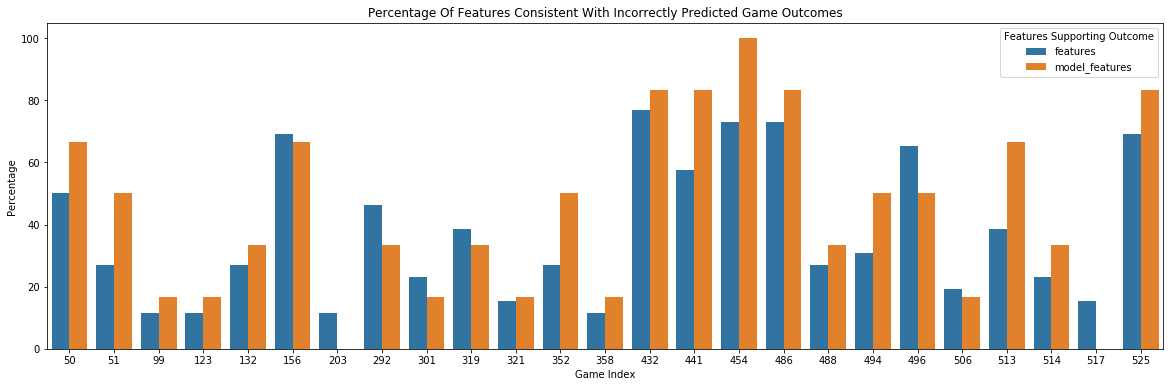

In [45]:
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Incorrectly Predicted Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Game Index')
m_plot.figure.set_size_inches(20,6)

#### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.

In [76]:
check_index = 454
missed_predictions[missed_predictions['game_index']== check_index][model_features]

,delta_fg_pct,delta_win_pct,delta_srs,delta_sos,delta_rth,delta_dol
454,-0.018,-0.014,-3.96,-2.16,20,25.0


In [ ]:
supporting_model_list = missed_predictions[missed_predictions['game_index']==check_index]['supporting_model_features']

In [ ]:
for item in supporting_model_list:
    print(item)

In [61]:
bdt.decision_function(X_test)
#X_test.shape
estimator_list = bdt.estimators_
estimator_list
#bdt.get_params(True)

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=155075710, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=718753187, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_lea

In [52]:

sample_tree.tree_.node_count

3

In [60]:
import graphviz 
from sklearn import tree

In [79]:
missed_predictions[missed_predictions['game_index']== check_index][model_features]

,delta_fg_pct,delta_win_pct,delta_srs,delta_sos,delta_rth,delta_dol
454,-0.018,-0.014,-3.96,-2.16,20,25.0


In [81]:
graphs= []

for i in np.arange(20):
    #print(i)
    f_name='tree' + str(i) + '.dot'
    #full_file_name = Path('../tree_files/' + f_name)
    #print(f_name)
    sample_tree= estimator_list[i]
    dot_data = tree.export_graphviz(sample_tree, out_file=None, 
                         feature_names=X_test.columns.values,   
                         filled=True, rounded=True,  
                         special_characters=True)  
    
    graphs.append(graphviz.Source(dot_data) ) 
    
    

#graphs[0]


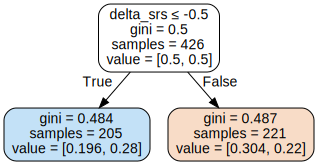

In [84]:
graphs[10]

In [83]:
X_test.loc[check_index].to_frame().transpose()
gen = bdt.staged_predict(X_test.loc[check_index].to_frame().transpose())
i=0
for item in gen:
    print(i,' ',item)
    i+= 1

0   [-1]
1   [-1]
2   [-1]
3   [-1]
4   [1]
5   [-1]
6   [-1]
7   [-1]
8   [-1]
9   [1]
10   [1]
11   [1]
12   [1]
13   [1]
14   [1]
15   [1]
16   [1]
17   [1]
18   [1]
19   [1]
20   [1]
21   [1]
22   [1]
23   [1]
24   [1]
25   [1]
26   [1]
27   [1]
28   [1]
29   [1]
30   [1]
31   [1]
32   [1]
33   [1]
34   [1]
35   [1]
36   [1]
37   [1]
38   [1]
39   [1]
40   [1]
41   [1]
42   [1]
43   [1]
44   [1]
45   [1]
46   [1]
47   [1]
48   [1]
49   [1]
50   [1]
51   [1]
52   [1]
53   [1]
54   [1]
55   [1]
56   [1]
57   [1]
58   [1]
59   [1]
60   [1]
61   [1]
62   [1]
63   [1]
64   [1]
65   [1]
66   [1]
67   [1]
68   [1]
69   [1]
70   [1]
71   [1]
72   [1]
73   [1]
74   [1]
75   [1]
76   [1]
77   [1]
78   [1]
79   [1]
80   [1]
81   [1]
82   [1]
83   [1]
84   [1]
85   [1]
86   [1]
87   [1]
88   [1]
89   [1]
90   [1]
91   [1]
92   [1]
93   [1]
94   [1]
95   [1]
96   [1]
97   [1]
98   [1]
99   [1]
100   [1]
101   [1]
102   [1]
103   [1]
104   [1]
105   [1]
106   [1]
107   [1]
108   [1]
109   [1]
11

In [58]:
X_test.loc[check_index].to_frame().transpose()
gen = bdt.staged_predict_proba(X_test.loc[check_index].to_frame().transpose())
i=0
for item in gen:
    print(i,' ',item)
    i+= 1

0   [[0.75829384 0.24170616]]
1   [[0.58539222 0.41460778]]
2   [[0.56643846 0.43356154]]
3   [[0.53917608 0.46082392]]
4   [[0.49922552 0.50077448]]
5   [[0.51273709 0.48726291]]
6   [[0.51524154 0.48475846]]
7   [[0.50345458 0.49654542]]
8   [[0.50109275 0.49890725]]
9   [[0.49532993 0.50467007]]
10   [[0.48762105 0.51237895]]
11   [[0.48554534 0.51445466]]
12   [[0.49061136 0.50938864]]
13   [[0.48931742 0.51068258]]
14   [[0.49082759 0.50917241]]
15   [[0.4904057 0.5095943]]
16   [[0.49324395 0.50675605]]
17   [[0.49569474 0.50430526]]
18   [[0.49465442 0.50534558]]
19   [[0.49628495 0.50371505]]
20   [[0.49460129 0.50539871]]
21   [[0.49605194 0.50394806]]
22   [[0.49716708 0.50283292]]
23   [[0.49617355 0.50382645]]
24   [[0.49805662 0.50194338]]
25   [[0.49589024 0.50410976]]
26   [[0.49445788 0.50554212]]
27   [[0.49367177 0.50632823]]
28   [[0.495471 0.504529]]
29   [[0.4927861 0.5072139]]
30   [[0.49437325 0.50562675]]
31   [[0.49418088 0.50581912]]
32   [[0.49463995 0.505360

## GridSearchCV

In [ ]:
X= feature_data[feature_data['season_t']>=2010]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

In [ ]:
from sklearn.model_selection import GridSearchCV
from time import time

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
param_grid ={
    "n_estimators": [21,51,101,201,401,601],
    "learning_rate": [0.01, .05, .1, .5, 1,5]
}

grid_search = GridSearchCV( AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME.R"), 
                           param_grid=param_grid, cv=5)

start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)



### Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_iter_search = 20
random_search = RandomizedSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME.R"), 
                                   param_distributions=param_grid,
                                   n_iter=n_iter_search, cv=5)
start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)